In [160]:
#Importing libraries

import pandas as pd
from pandas import merge
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as skl
import nltk
import csv
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

#Preprocessing
from sklearn.model_selection import train_test_split
#keras
from keras.layers import LSTM, Embedding, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.utils import resample

#Modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from keras.models import Sequential

#Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [ ]:
"""#Declaring filepath and name for the csv file
filepath = 'smsdata/SMSSPamCollection.txt'
csv_data = 'smsdata/smsdata.csv'

#Turning the .txt file into a csv file
with open(filepath, 'r') as file:
    lines = file.readlines()

data = []

for line in lines:
    line = line.strip()
    parts = line.split('\t')
    label = parts[0]
    message = parts[1]
    data.append([label, message])

with open(csv_data, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(data)
"""

#### Arrumando o dataset com o header certo

In [2]:
csv_data = 'smsdata/smsdata.csv'

dtsms = pd.read_csv(csv_data, header=None, names=['Label', 'Message'], delimiter=',')

dtsms.head()

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### Tratando dados 

Tirei caracteres especiais, dropei dados duplicados, removi stopwords, coloquei tudo em lowercase e realizei stemming

In [3]:
#Removendo caracteres especiais
dtsms['Message'] = dtsms['Message'].apply(lambda x: re.sub(r'\W', ' ', x))

#drop de dados duplicados
dtsms.drop_duplicates(inplace=True)

#to lowercase
dtsms['Message'] = dtsms['Message'].str.lower()

#nltk stopwords download
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
#lambda para remover stopwords
dtsms['Message'] = dtsms['Message'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

#stemming
stemmer = PorterStemmer()

dtsms['Message'] = dtsms['Message'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anagi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Vetorização com TfidfVectorizer - pegando palavras frequentes

In [15]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(dtsms['Message'])
y = dtsms['Label']

#Dividir dados em treino e teste 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#Replacing values to binaries
dtsms['Label'].replace({'ham':0, 'spam':1}, inplace = True)

In [16]:
dtsms.head()

,Label,Message
0,0,go jurong point crazi avail bugi n great world...
1,0,ok lar joke wif u oni
2,1,free entri 2 wkli comp win fa cup final tkt 21...
3,0,u dun say earli hor u c alreadi say
4,0,nah think goe usf live around though


#### Treino do RandomForest e predição

In [18]:
#Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy  = accuracy_score(y_test, y_pred)

prec = precision_score(y_test, y_pred, pos_label = 1)

rec = recall_score(y_test, y_pred, pos_label = 1)

f1 = f1_score(y_test, y_pred, pos_label = 1)

print("Acuracia com RandomForest:{:.2f}%".format(accuracy * 100))
print("Precisão com RandomForest:{:.2f}%".format(prec * 100))
print("Recall Score com RandomForest:{:.2f}%".format(rec * 100))
print("F1-Score com RandomForest:{:.2f}%".format(f1 * 100))

Acuracia com RandomForest:97.38%
Precisão com RandomForest:97.06%
Recall Score com RandomForest:80.49%
F1-Score com RandomForest:88.00%


#### SVM - SVC

In [20]:
svc = SVC()

svc.fit(X_train, y_train)
previsao = svc.predict(X_test)

precision = precision_score(y_test, previsao, pos_label=1)

fscore = f1_score(y_test, previsao, pos_label = 1)

recall = recall_score(y_test, previsao, pos_label = 1)

acuracia = accuracy_score(y_test, previsao)

print("Acuracia com SVC:{:.2f}%".format(acuracia * 100))
print("Precisão com SVC:{:.2f}%".format(precision * 100))
print("Recall Score com SVC:{:.2f}%".format(recall * 100))
print("F1-Score com SVC:{:.2f}%".format(fscore * 100))

Acuracia com SVC:97.29%
Precisão com SVC:98.97%
Recall Score com SVC:78.05%
F1-Score com SVC:87.27%


#### LSTM

In [161]:
max_len = 100
max_words = 1000

#Divisão em treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(dtsms['Message'], dtsms['Label'], test_size=0.2, random_state=42)

train_df = pd.concat([X_treino, y_treino], axis=1)

ham_df = train_df[train_df['Label'] == 0]
spam_df = train_df[train_df['Label'] == 1]

spam_upsampled = resample(spam_df, replace=True, n_samples=len(ham_df), random_state=42)

# Combinar novamente as classes majoritária e minoritária
balanced_train_df = pd.concat([ham_df, spam_upsampled])

# Dividir novamente os dados de treinamento em X_train e y_train
X_train_balanced = balanced_train_df['Message']
y_train_balanced = balanced_train_df['Label']


tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_balanced)

X_train_sequences = tokenizer.texts_to_sequences(X_train_balanced)
X_test_sequences = tokenizer.texts_to_sequences(X_teste)

vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(sequence) for sequence in X_train_sequences)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length)

In [162]:
#Building model
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 78, 100)           645500    
                                                                 
 lstm_9 (LSTM)               (None, 100)               80400     
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 726,001
Trainable params: 726,001
Non-trainable params: 0
_________________________________________________________________


In [163]:
model.fit(X_train_padded, y_train_balanced, validation_data=(X_test_padded, y_test), epochs=10, batch_size=64)

Epoch 1/10
113/113 [==============================] - 24s 154ms/step - loss: 0.2085 - accuracy: 0.9217 - val_loss: 0.0601 - val_accuracy: 0.9855
Epoch 2/10
113/113 [==============================] - 16s 140ms/step - loss: 0.0121 - accuracy: 0.9971 - val_loss: 0.0541 - val_accuracy: 0.9884
Epoch 3/10
113/113 [==============================] - 16s 143ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.0745 - val_accuracy: 0.9845
Epoch 4/10
113/113 [==============================] - 17s 151ms/step - loss: 6.2368e-04 - accuracy: 1.0000 - val_loss: 0.0688 - val_accuracy: 0.9884
Epoch 5/10
113/113 [==============================] - 16s 145ms/step - loss: 2.7351e-04 - accuracy: 1.0000 - val_loss: 0.0851 - val_accuracy: 0.9855
Epoch 6/10
113/113 [==============================] - 16s 143ms/step - loss: 1.3925e-04 - accuracy: 1.0000 - val_loss: 0.1004 - val_accuracy: 0.9835
Epoch 7/10
113/113 [==============================] - 17s 148ms/step - loss: 1.3116e-04 - accuracy: 1.0000 - val_loss:

In [165]:
y_lstm_pred = model.predict(X_test_padded)
y_lstm_pred = np.where(y_lstm_pred > 0.5, 1, 0)


print(classification_report(y_teste, y_lstm_pred))

33/33 [==============================] - 2s 29ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       909
           1       0.96      0.91      0.93       123

    accuracy                           0.98      1032
   macro avg       0.97      0.95      0.96      1032
weighted avg       0.98      0.98      0.98      1032



#### Matriz de confusão

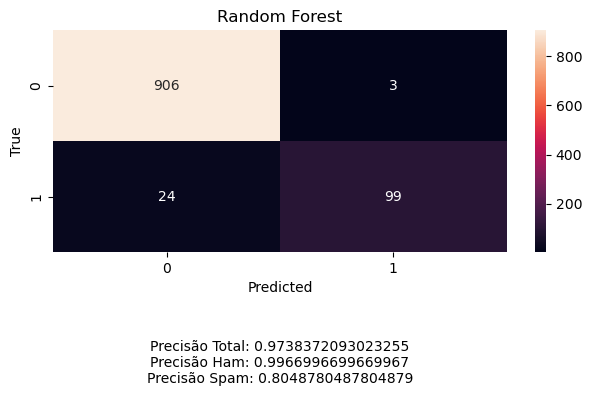

In [174]:
#rf - y_pred
#svc - previsao
#y_pred_lstm= model.predict(X_test_padded)
#classes_pred = np.argmax(y_pred_lstm, axis=1)

cm_rf = confusion_matrix(y_test, y_pred)
cm_svc = confusion_matrix(y_test, previsao)
cm_lstm = confusion_matrix(y_teste, y_lstm_pred)

#Função para calcular precisão
def calculate_precision(cm):
    accuracy = (cm[0][0] + cm[1][1]) / np.sum(cm)
    precision_ham = cm[0][0] / np.sum(cm[0])
    precision_spam = cm[1][1] / np.sum(cm[1])
    return accuracy, precision_ham, precision_spam

# Calcular precisão total e precisão por tipos para cada modelo
accuracy_rf, precision_ham_rf, precision_spam_rf = calculate_precision(cm_rf)
accuracy_svc, precision_ham_svc, precision_spam_svc = calculate_precision(cm_svc)

#Heatmap Random Forest 
fig, ax = plt.subplots()
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='rocket', ax=ax)
ax.set_title('Random Forest')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.text(0.5, -0.5, f"Precisão Total: {accuracy_rf}\nPrecisão Ham: {precision_ham_rf}\nPrecisão Spam: {precision_spam_rf}", ha='center', va='center', transform=ax.transAxes)


plt.tight_layout()
plt.show()

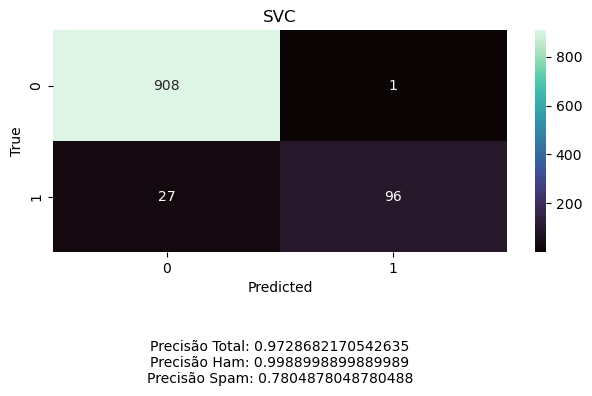

In [170]:
#Heatmap SVC
fig, ax = plt.subplots()
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='mako', ax=ax)
ax.set_title('SVC')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.text(0.5, -0.5, f"Precisão Total: {accuracy_svc}\nPrecisão Ham: {precision_ham_svc}\nPrecisão Spam: {precision_spam_svc}", ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

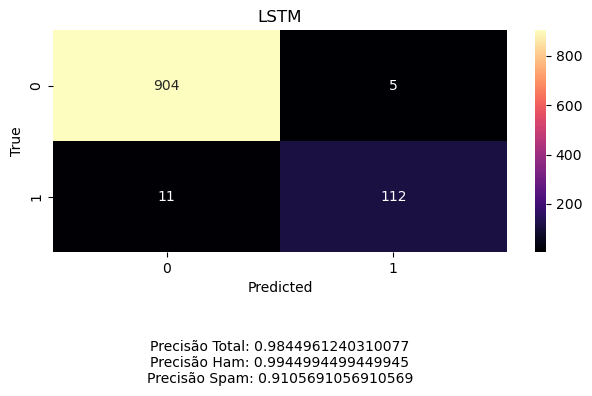

In [179]:
# Calcular a precisão geral, precisão de ham e precisão de spam
accuracy_lstm = accuracy_score(y_teste, y_lstm_pred)
precision_ham_lstm = cm_lstm[0, 0] / (cm_lstm[0, 0] + cm_lstm[0, 1])
precision_spam_lstm = cm_lstm[1, 1] / (cm_lstm[1, 0] + cm_lstm[1, 1])

fig, ax = plt.subplots()
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='magma', ax=ax)
ax.set_title('LSTM')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.text(0.5, -0.5, f"Precisão Total: {accuracy_lstm}\nPrecisão Ham: {precision_ham_lstm}\nPrecisão Spam: {precision_spam_lstm}", ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()